In [ ]:
%load_ext autoreload 
%autoreload 2

import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(os.path.join(os.getcwd(), ".."))

import math
import numpy as np
import pandas as pd
from numpy import array
from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq
from math import sin, pi
from scipy import signal
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.signal import savgol_filter
import random

import importlib
import model as md
import view as vw
from tqdm import tqdm

importlib.reload(md)
importlib.reload(vw)

c:\Users\Артем\Desktop\Вуз\Аспирантура\Диссертация\Алгоритм\Relaxation_frequency_phase_algorithm\notebooks\Complex_ms\Big_statistics\..


<module 'view' from 'c:\\Users\\Артем\\Desktop\\Вуз\\Аспирантура\\Диссертация\\Алгоритм\\Relaxation_frequency_phase_algorithm\\view\\__init__.py'>

In [2]:
def monte_carlo_phase(phase_method,num_iter=1000):
    results = []

    for i in tqdm(range(num_iter), desc=f"Метод {phase_method.__name__}", unit=" шага"):

        # --- Случайные параметры ---
        F=random.randrange(int(300e3), int(500e3), int(50e3))
        T=1/F
        fs_mult = random.randrange(3, 100, 1)

        duration_T=random.randrange(3, 100, 1)
        duration = duration_T * T
        window_T = np.random.uniform(1, duration_T-1)
        
        phase=random.randrange(1, 180, 1)

        # --- Генерация сигналов ---
        t = np.arange(0, duration, 1/(fs_mult*F))
        U = md.generate_sin(t,F,2)
        I = md.generate_sin(t,F,2,phase)

        # --- Добавление шума ---
        snr_db = random.uniform(20, 60)
        noise_power = np.mean(U**2) / (10**(snr_db / 10))
        noise = np.sqrt(noise_power) * np.random.randn(len(U))
        U += noise
        I += noise
        
        time, phase_vals = phase_method(t, U, I, F, int(window_T))
        phase_KDE = md.get_kde_mode(phase_vals)
        err_deg = (phase_KDE - phase + 180) % 360 - 180

        # --- Ошибка ---
        phase_error = (phase_KDE - phase + 180) % 360 - 180
        abs_error = np.abs(phase_error)

        # --- Сохраняем результаты ---
        results.append({
            "F": F,
            "fs_mult": fs_mult,
            "duration": duration_T,
            "window": window_T,
            "snr_db": snr_db,
            "phase_true": phase,
            "phase_estimated": phase_KDE,
            "phase_error_deg": abs_error
        })

    return pd.DataFrame(results)

In [3]:
phase_methods = [
    md.get_phase_maxpoint,
    md.get_phase_hilbert,
    md.get_phase_FFT,
    md.get_phase_lockin,
    md.get_phase_xcorr2
]

Y=[]
for i in range(0,len(phase_methods),1):
    Y.append(monte_carlo_phase(phase_methods[i], 5000))


Метод get_phase_xcorr2: 100%|██████████| 5000/5000 [00:09<00:00, 517.67 шага/s]


In [ ]:
def smooth(y, window_length=9, polyorder=2):
    wl = min(window_length, len(y) if len(y)%2==1 else len(y)-1)
    wl = max(3, wl)
    try:
        return savgol_filter(y, wl, polyorder)
    except Exception:
        return y

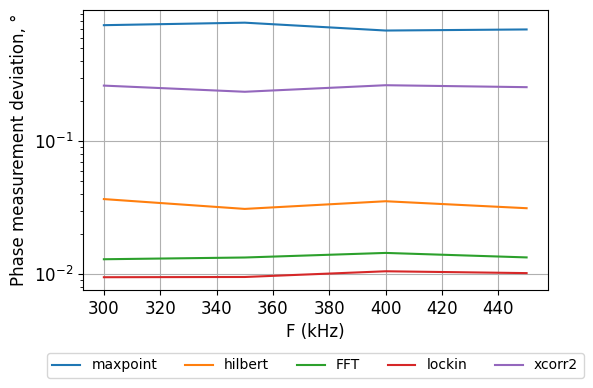

In [27]:
def clean_name(func):
    return func.__name__.replace("get_phase_", "").replace("get_phase", "")

method_names = [clean_name(m) for m in phase_methods]

fig = plt.figure(figsize=(6, 8))
gs = fig.add_gridspec(2, 1)
front = 12
ax1 = fig.add_subplot(gs[0, 0])

for i in range(len(Y)):
    median_error = Y[i].groupby("F")["phase_error_deg"].median()
    ax1.plot(median_error.index / 1e3,median_error, label=method_names[i])


ax1.set_xlabel('F (kHz)', fontsize=front)
ax1.set_ylabel('Phase measurement deviation, °', fontsize=front)
ax1.tick_params(axis='both', labelsize=front)
ax1.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(method_names))
ax1.set_yscale('log')

In [ ]:
def find_plateau_by_derivative(fs_vals, metric, tol_abs=None, tol_rel=0.01, smooth_win=9, M=5):
    fs = np.asarray(fs_vals)
    y = np.asarray(metric)
    y_s = smooth(y, window_length=smooth_win)
    dy = np.gradient(y_s, fs)
    # threshold
    if tol_abs is None:
        tol = tol_rel * max(1e-12, y_s[0] - np.median(y_s[-max(1,len(y_s)//10):]))  # relative to total drop
    else:
        tol = tol_abs
    strong = np.abs(dy) < tol
    for i in range(len(fs) - M + 1):
        if np.all(strong[i:i+M]):
            return i, fs[i]
    return None, None

def find_plateau_by_fraction(fs_vals, metric, frac=0.95, smooth_win=9, tailK=10):
    fs = np.asarray(fs_vals)
    y = np.asarray(metric)
    y_s = smooth(y, window_length=smooth_win)
    start = y_s[0]
    # asymptote: медиана последних tailK точек (устойчивее)
    tail = y_s[-min(tailK, len(y_s)):]
    end = np.median(tail)
    total = start - end
    if total <= 0:
        return None, None
    rel = (start - y_s) / total
    idxs = np.where(rel >= frac)[0]
    if len(idxs) > 0:
        return idxs[0], fs[idxs[0]]
    return None, None

def find_elbow_kneedle(fs_vals, metric, smooth_win=9):
    # более стабильный вариант: расстояние до прямой (x0,y0)-(xn,yn)
    x = np.asarray(fs_vals, dtype=float)
    y = np.asarray(metric, dtype=float)
    y_s = smooth(y, window_length=smooth_win)
    x0, xn = x[0], x[-1]
    y0, yn = y_s[0], y_s[-1]
    # line param: project each point on line and get distance
    # compute distance from point (xi, yi) to line through (x0,y0)-(xn,yn)
    A = yn - y0
    B = x0 - xn
    C = xn*y0 - x0*yn
    dist = np.abs(A*x + B*y_s + C) / np.sqrt(A*A + B*B + 1e-18)
    idx = np.argmax(dist)
    return idx, x[idx]

# Пример использования:
for i, (fs_vals, metric) in enumerate(median_results[:50]):

    i1, fs1 = find_plateau_by_derivative(fs_vals[:4000], metric[:4000], tol_rel=0.01)
    i2, fs2 = find_plateau_by_fraction  (fs_vals[:4000], metric[:4000], frac=0.95)
    i3, fs3 = find_elbow_kneedle        (fs_vals[:4000], metric[:4000])

    print(f"\nМетод: {method_names[i]}")
    print(f"  ➤ Плато по производной: ≈ {fs1}")
    print(f"  ➤ Плато по 95% улучшения: ≈ {fs2}")
    print(f"  ➤ Колено кривой: ≈ {fs3}")



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# suppose errs = массив abs_error по порядку генерации (len = N)
def running_stats(arr):
    arr = np.asarray(arr)
    cummean = np.cumsum(arr) / np.arange(1, len(arr)+1)
    cumvar = (np.cumsum(arr**2) - np.arange(1, len(arr)+1) * cummean**2) / np.arange(1, len(arr)+1)
    cusd = np.sqrt(np.maximum(cumvar, 0))
    se = cusd / np.sqrt(np.arange(1, len(arr)+1))
    return cummean, se

cummean, se = running_stats(df['phase_error_deg'].values)
plt.fill_between(np.arange(len(cummean)), cummean-1.96*se, cummean+1.96*se, alpha=0.2)
plt.plot(cummean)
plt.xlabel('Iterations'); plt.ylabel('Mean abs error'); plt.show()